Кластеризация данных о пассажирах авиакомпаний

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import colors

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from yellowbrick.cluster import KElbowVisualizer

from sklearn.preprocessing import LabelEncoder


from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

sns.set_theme(style="whitegrid")


Описание датасета

Исходный датасет состоит из 103 904 записей и 25 признаков, среди которых представлены демографические характеристики, параметры полета и оценки качества обслуживания. 

Признаки как числовые, так и категориальные. К числовым относятся возраст, расстояние полета и различные оценки качества сервиса, к категориальным - пол, тип клиента, класс обслуживания, тип поездки и уровень удовлетворенности пассажиров. 

Анализ пропусков выявил единичные отсутствующие значения в признаке Arrival Delay in Minutes (310 записей).

Гистограммы ключевых числовых признаков показали ненормальность распределений.

Распределения числовых признаков (например, возраст, задержки) демонстрируют правостороннюю асимметрию: значительная часть пассажиров - взрослые (медианный возраст 40 лет), большинство перелетов - средней и большой дальности, при этом задержки часто отсутствуют, но имеют редкие экстремальные значения (до 1592 минут). Категориальные признаки показывают преобладание лояльных клиентов (82 %), бизнес-путешествий (69 %) и удовлетворенности на уровне 43 %. Выявлено 310 пропущенных значений в Arrival Delay in Minutes, а также 3103 нулевых оценок по Inflight wifi service, интерпретированных как отсутствие данных и удалённых из анализа. Класс Eco Plus исключён из-за малочисленности.

In [ ]:
data = pd.read_csv("train.csv")

# Основная информация о датасете
print("Shape:", data.shape)
print(data.info())
print("Missing values:\n", data.isnull().sum())
display(data.describe().T)

# Проверка распределения категориальных признаков
cat_cols = ['Gender', 'Customer Type', 'Type of Travel', 'Class', 'satisfaction']
for col in cat_cols:
    print(f"{col} distribution:\n", data[col].value_counts(), "\n")

# Проверка распределения числовых признаков
num_cols = ["Age", "Flight Distance", "Inflight wifi service",
            "Departure/Arrival time convenient", "Ease of Online booking", "Seat comfort"]
plt.figure(figsize=(12, 8))
for i, col in enumerate(num_cols, 1):
    plt.subplot(2, 3, i)
    plt.hist(data[col].dropna(), bins=30, color='skyblue', edgecolor='black')
    plt.title(col)
plt.tight_layout()
plt.show()

Shape: (440, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB
None
Missing values:
 Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64


,count,mean,std,min,25%,50%,75%,max
Channel,440.0,1.322727,0.468052,1.0,1.00,1.0,2.00,2.0
Region,440.0,2.543182,0.774272,1.0,2.00,3.0,3.00,3.0
Fresh,440.0,12000.297727,12647.328865,3.0,3127.75,8504.0,16933.75,112151.0
Milk,440.0,5796.265909,7380.377175,55.0,1533.00,3627.0,7190.25,73498.0
Grocery,440.0,7951.277273,9503.162829,3.0,2153.00,4755.5,10655.75,92780.0
Frozen,440.0,3071.931818,4854.673333,25.0,742.25,1526.0,3554.25,60869.0
Detergents_Paper,440.0,2881.493182,4767.854448,3.0,256.75,816.5,3922.00,40827.0
Delicassen,440.0,1524.870455,2820.105937,3.0,408.25,965.5,1820.25,47943.0


KeyError: 'Gender'

Все категориальные переменные закодированы бинарно (0/1). Числовые признаки масштабированы с использованием StandardScaler, что обеспечивает равный вклад всех переменных в расстояние при кластеризации. 

Из-за сильной корреляции между Departure Delay и Arrival Delay (0.97) второй признак удалён. 

Для снижения размерности и визуализации применён PCA: выбраны первые три главные компоненты, объясняющие основную дисперсию данных (суммарно >80 %).

In [62]:
# Удаляем строки с некорректными/нулевыми значениями
data = data[data['Inflight wifi service'] != 0]
data = data[data['Class'] != 'Eco Plus']

# Преобразуем категориальные признаки в числовые
mapping = {
    'Gender': {'Female': 0, 'Male': 1},
    'Customer Type': {'Loyal Customer': 0, 'disloyal Customer': 1},
    'Type of Travel': {'Business travel': 0, 'Personal Travel': 1},
    'Class': {'Business': 0, 'Eco': 1},
    'satisfaction': {'neutral or dissatisfied': 0, 'satisfied': 1}
}
data = data.replace(mapping)

# Удаляем лишние столбцы
data = data.drop(columns=['id', 'Unnamed: 0', 'Arrival Delay in Minutes'])

satisfaction = data['satisfaction'].copy()
data = data.drop(columns=['satisfaction'])

C:\Users\vfvjx\AppData\Local\Temp\ipykernel_12556\4168647904.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data = data.replace(mapping)


In [63]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

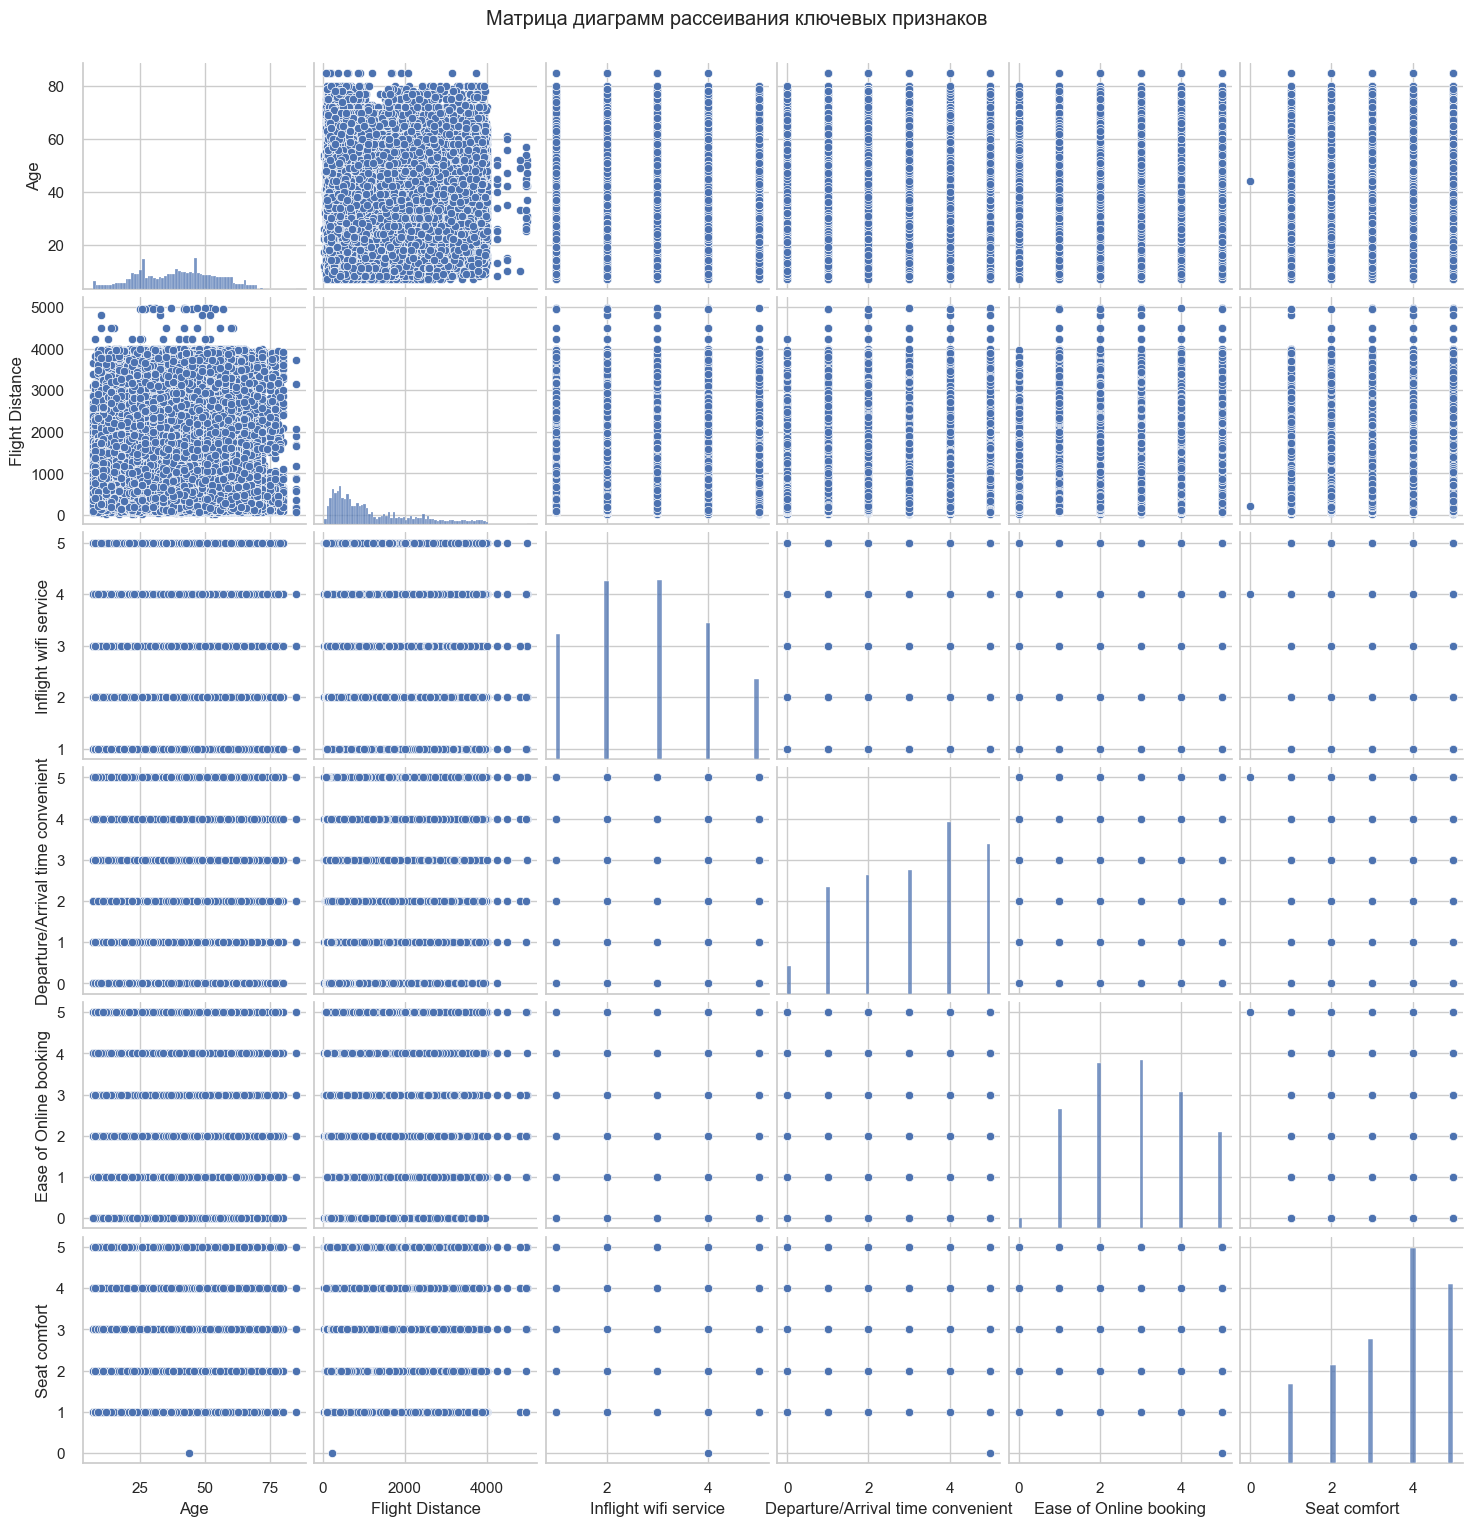

In [64]:
# PCA для снижения размерности для визуализации
pca = PCA(n_components=3, random_state=42)
data_pca = pd.DataFrame(pca.fit_transform(data_scaled), columns=['PC1', 'PC2', 'PC3'])

# Матрица диаграмм рассеивания ключевых признаков
key_features = ["Age", "Flight Distance", "Inflight wifi service",
                "Departure/Arrival time convenient", "Ease of Online booking", "Seat comfort"]
sns.pairplot(data[key_features])
plt.suptitle("Матрица диаграмм рассеивания ключевых признаков", y=1.02)
plt.show()

С использованием метода локтя (через KElbowVisualizer) на PCA-пространстве было установлено, что оптимальное число кластеров для K-means - 4.

Кластеризация с использованием KMeans позволила выявить 4 различимые группы пассажиров, которые визуализированы в трехмерном пространстве PCA.

Silhouette Score очень низкий (0.105) - кластеры плохо отделены, границы размытые.
Calinski-Harabasz Score довольно высокий (10345) - внутреннее распределение плотное, но из-за большого объёма данных это не гарантирует хорошую кластеризацию.

Вывод: кластеры существуют, но выражены слабо, границы между ними нечёткие.

Профили кластеров:

Cluster 0: старшие бизнес-путешественники, довольны сервисом.

Cluster 1: молодые, недовольные, эконом-класс, короткие полеты.

Cluster 2: редкие бизнес-путешественники, критичны к wifi и расписанию.

Cluster 3: семьи на отдыхе, ценят сервис и пространство.

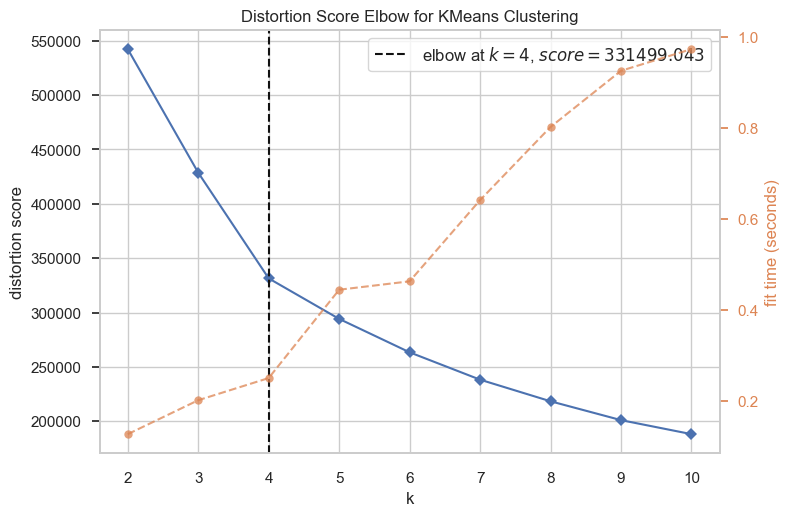

Optimal k: 4


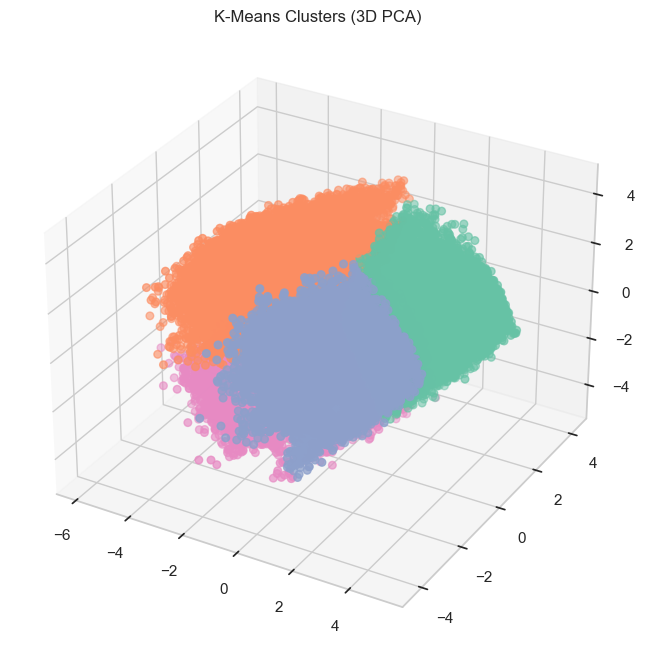

Silhouette Score: 0.105, Calinski-Harabasz Score: 10345.783


KMeansCluster,0,1,2,3
Gender,0.497695,0.544018,0.494462,0.440888
Customer Type,0.107986,0.334432,0.160722,0.151943
Age,42.119962,32.801953,40.811613,42.092518
Type of Travel,0.153528,0.464858,0.193755,0.383424
Class,0.242328,0.757238,0.301000,0.650127
Flight Distance,1541.972856,849.923883,1443.324909,1063.349873
Inflight wifi service,4.016192,2.428511,1.945499,2.654300
Departure/Arrival time convenient,4.010125,3.096023,2.025518,2.976881
Ease of Online booking,3.994169,2.579054,1.814930,2.783374
Gate location,3.834141,2.971768,1.925104,2.993073


In [65]:
# Определяем оптимальное число кластеров методом локтя
elbow = KElbowVisualizer(KMeans(n_init=10, random_state=42), k=10)
elbow.fit(data_pca)
elbow.show()
optimal_k = elbow.elbow_value_
print("Optimal k:", optimal_k)

# Строим модель K-Means
kmeans = KMeans(n_clusters=optimal_k, n_init=10, random_state=42)
kmeans_labels = kmeans.fit_predict(data_pca)
data_pca['KMeansCluster'] = kmeans_labels
data['KMeansCluster'] = kmeans_labels

# Визуализация кластеров
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
cmap = colors.ListedColormap(sns.color_palette("Set2", optimal_k))
ax.scatter(data_pca['PC1'], data_pca['PC2'], data_pca['PC3'], c=data_pca['KMeansCluster'], cmap=cmap, s=30)
ax.set_title("K-Means Clusters (3D PCA)")
plt.show()

# Метрики качества
sil_score = silhouette_score(data_scaled, kmeans_labels)
ch_score = calinski_harabasz_score(data_scaled, kmeans_labels)
print(f"Silhouette Score: {sil_score:.3f}, Calinski-Harabasz Score: {ch_score:.3f}")

# Профили кластеров
cluster_profiles = data.groupby('KMeansCluster').mean().T
display(cluster_profiles.style.background_gradient(cmap='RdYlGn', axis=1))

Иерархическая кластеризация проводилась с использованием расстояния Хэмминга для категориальных признаков. Дендограмма позволила визуально оценить структуру данных. Анализ профилей кластеров показал, что иерархический метод формирует группы, аналогичные KMeans, однако распределение объектов по кластерам более неравномерное.

Метрики качества:

Silhouette Score (Hamming distance): 0.121
Метрика низкая, что указывает на значительное перекрытие кластеров и слабую разделимость. Значение сопоставимо с результатами K-Means и подтверждает сложность структурирования данных.

Calinski–Harabasz Score: 451.871
Показатель существенно ниже, чем на полной выборке (как у K-Means), что ожидаемо, поскольку используется подвыборка из 5000 объектов и кластеры менее компактны.

Davies–Bouldin Score: 2.880
Значение высокое, что говорит о размытых и близко расположенных кластерах. Это подтверждает, что данные сложно сегментируются в низкоразмерном пространстве расстояний Хэмминга.

Профили кластеров:

Cluster 1
Относительно молодые пассажиры, преимущественно эконом-класс, с умеренно критичной оценкой сервиса. Типичны личные поездки.

Cluster 2
Также молодые пассажиры, чаще эконом-класс, но с несколько более низкими оценками услуг (низкие значения "wifi service", "entertainment", "service").

Cluster 3
Более взрослые пассажиры, длинные перелёты, высокие оценки комфорта и развлечений. Это группа с более позитивным общим впечатлением.

Cluster 4 (самый крупный кластер)
Смешанный состав среднего возраста, стабильные умеренно высокие оценки по большинству сервисных параметров. Наиболее "сбалансированный" сегмент.

Cluster 5
Пассажиры среднего возраста, эконом/бизнес, с довольно высокими оценками большинства сервисов, но немного ниже по отдельным аспектам посадки и компоновки.

Cluster 6
Молодые пассажиры с короткими перелётами, оценки сервиса преимущественно средние. Это "нейтральная" группа.

Cluster 7
Самый маленький и выделенный кластер: возраст старше среднего, чрезвычайно длинные перелёты (Flight Distance >2000), низкие оценки большинства сервисов. Эмоционально неудовлетворённая группа.

Cluster 8
Пассажиры старшего возраста, длинные перелёты, оценки сервисов выше, чем у кластера 7, но ниже, чем в кластерах 3 и 5. Средняя удовлетворённость.

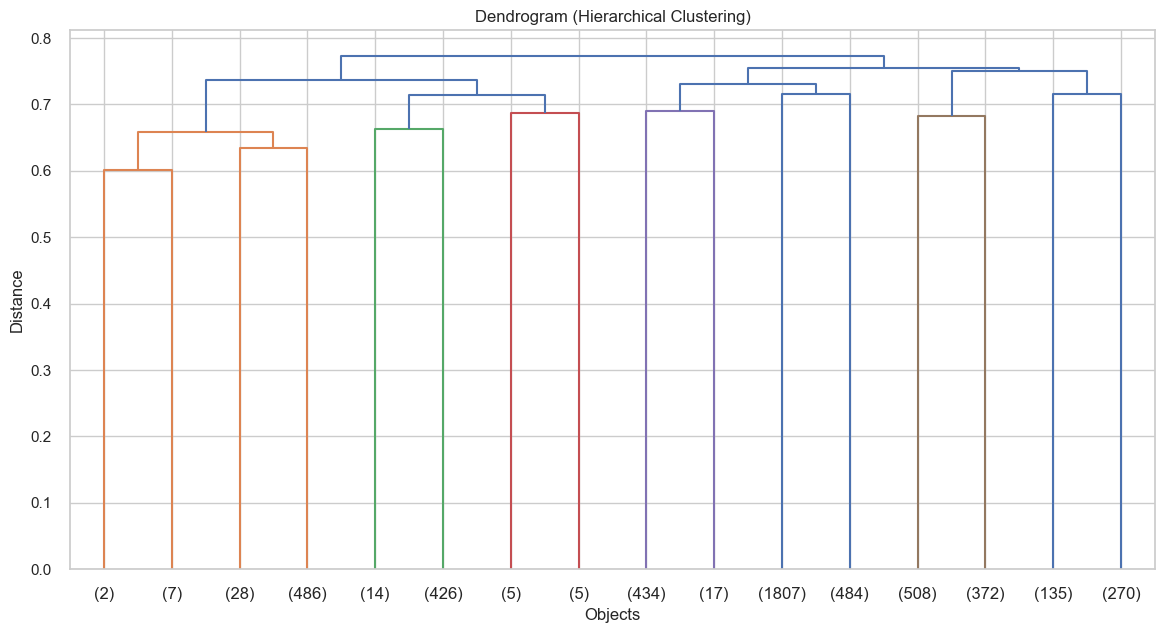

k = 2, silhouette score = 0.0939
k = 3, silhouette score = 0.1014
k = 4, silhouette score = 0.1037
k = 5, silhouette score = 0.1158
k = 6, silhouette score = 0.1161
k = 7, silhouette score = 0.1176
k = 8, silhouette score = 0.1210
k = 9, silhouette score = 0.1133
k = 10, silhouette score = 0.1014
k = 11, silhouette score = 0.0860
k = 12, silhouette score = 0.0821
k = 13, silhouette score = 0.0737
k = 14, silhouette score = 0.0931
k = 15, silhouette score = 0.1039
k = 16, silhouette score = 0.1005
k = 17, silhouette score = 0.0961
k = 18, silhouette score = 0.0909
k = 19, silhouette score = 0.0876
k = 20, silhouette score = 0.0935

Лучшее число кластеров: 8
Лучший silhouette score: 0.12103304053250388

Размеры кластеров:
HierCluster
4    1807
6     880
1     523
5     484
3     451
2     450
8     270
7     135
Name: count, dtype: int64

Профили кластеров:


,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,KMeansCluster
HierCluster,,,,,,,,,,,,,,,,,,,,,
1,1,0,25,0,1,528,2,4,3,3,...,2,2,4,3,4,3,4,2,0,1
2,1,0,24,0,1,399,1,4,2,3,...,1,1,3,4,4,4,4,1,0,1
3,1,0,37,0,1,853,2,4,3,3,...,5,5,3,4,4,3,4,5,0,2
4,0,0,42,0,0,337,4,4,3,3,...,4,4,4,4,4,4,4,4,0,0
5,1,0,36,0,1,589,4,4,2,3,...,4,4,4,2,4,4,4,4,0,3
6,1,0,27,0,1,337,3,4,3,3,...,3,3,3,3,3,3,3,3,0,3
7,0,0,47,0,0,2306,1,5,3,3,...,4,1,1,1,1,3,1,3,0,3
8,0,0,49,0,0,1660,2,4,4,4,...,4,2,2,2,2,3,2,4,0,3


In [66]:
sample = data.sample(5000, random_state=42).copy()

# Матрица расстояний (Hamming)
dist_matrix = pdist(sample, metric='hamming')
dist_square = squareform(dist_matrix)

# Иерархическая кластеризация (дендрограмма)
Z = linkage(dist_matrix, method='average')

plt.figure(figsize=(14, 7))
dendrogram(
    Z, 
    truncate_mode='level',
    p=3, 
    color_threshold=0.7
)
plt.title("Dendrogram (Hierarchical Clustering)")
plt.xlabel("Objects")
plt.ylabel("Distance")
plt.show()

# Силуэтный анализ для выбора оптимального k
silhouette_scores = {}
k_values = range(2, 21)

for k in k_values:
    labels = fcluster(Z, k, criterion='maxclust')
    
    score = silhouette_score(dist_square, labels, metric='precomputed')
    
    silhouette_scores[k] = score
    print(f"k = {k}, silhouette score = {score:.4f}")

# Находим оптимальное k
best_k = max(silhouette_scores, key=silhouette_scores.get)
print("\nЛучшее число кластеров:", best_k)
print("Лучший silhouette score:", silhouette_scores[best_k])

hier_labels = fcluster(Z, best_k, criterion='maxclust')
sample['HierCluster'] = hier_labels

print("\nРазмеры кластеров:")
print(sample['HierCluster'].value_counts())

# Профили кластеров
cluster_profiles_hier = sample.groupby('HierCluster').agg(
    lambda x: x.value_counts().index[0]
)

print("\nПрофили кластеров:")
display(cluster_profiles_hier)

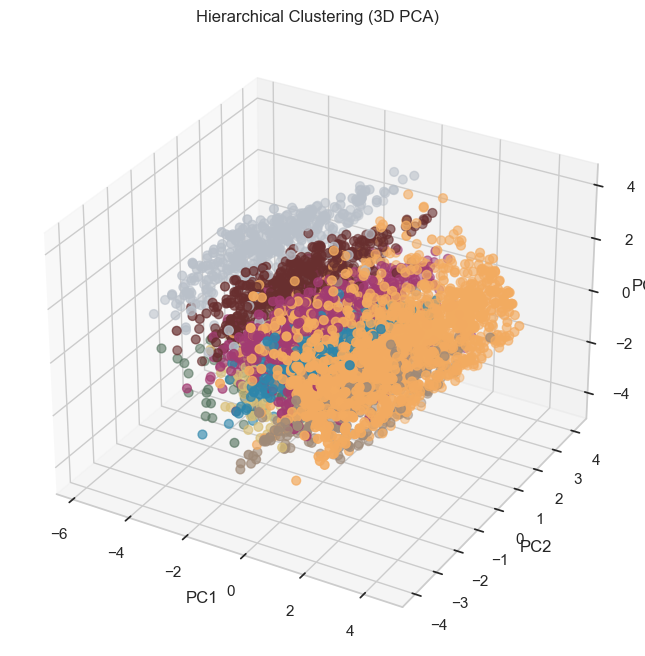

In [ ]:
cat_cols_sample = [
    'Gender',
    'Customer Type',
    'Type of Travel',
    'Class',
    'Inflight wifi service',
    'Departure/Arrival time convenient',
    'Ease of Online booking',
    'Gate location',
    'Food and drink',
    'Online boarding',
    'Seat comfort',
    'Inflight entertainment',
    'On-board service',
    'Leg room service',
    'Baggage handling',
    'Checkin service',
    'Inflight service',
    'Cleanliness'
]

sample_encoded = sample.copy()
for col in cat_cols_sample:
    le = LabelEncoder()
    sample_encoded[col] = le.fit_transform(sample_encoded[col])

scaler = StandardScaler()
sample_scaled = scaler.fit_transform(sample_encoded[cat_cols_sample])

pca = PCA(n_components=3, random_state=42)
sample_pca = pca.fit_transform(sample_scaled)
sample_pca_df = pd.DataFrame(sample_pca, columns=['PC1', 'PC2', 'PC3'])
sample_pca_df['Cluster'] = sample['HierCluster'].values

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

num_clusters = sample['HierCluster'].nunique()
cmap = colors.ListedColormap([
    '#682F2F','#B9C0C9','#9F8A78','#F3AB60',
    '#2E86AB','#A23B72','#4E6E58','#D9BF77'
][:num_clusters])

scatter = ax.scatter(
    sample_pca_df['PC1'], 
    sample_pca_df['PC2'], 
    sample_pca_df['PC3'], 
    c=sample_pca_df['Cluster'], 
    cmap=cmap, 
    s=40
)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title("Hierarchical Clustering (3D PCA)")

plt.show()


In [68]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.spatial.distance import squareform

dist_square = squareform(dist_matrix)

# Silhouette Score (используем precomputed)
sil_score = silhouette_score(dist_square, hier_labels, metric='precomputed')

num_cols = sample.select_dtypes(include=np.number).columns
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
sample_scaled = scaler.fit_transform(sample[num_cols])

ch_score = calinski_harabasz_score(sample_scaled, hier_labels)
db_score = davies_bouldin_score(sample_scaled, hier_labels)

print(f"Hierarchical Clustering Metrics:")
print(f"Silhouette Score (Hamming distance): {sil_score:.3f}")
print(f"Calinski-Harabasz Score: {ch_score:.3f}")
print(f"Davies-Bouldin Score: {db_score:.3f}")


Hierarchical Clustering Metrics:
Silhouette Score (Hamming distance): 0.121
Calinski-Harabasz Score: 276.704
Davies-Bouldin Score: 4.357


K-Means: кластеры относительно равномерные, но низкая Silhouette говорит о пересечении кластеров.

Иерархическая кластеризация: кластеры сильно неравномерны по численности. Выделяются маленькие, специфические группы.

In [69]:
print("K-Means vs Hierarchical cluster sizes:")
print(data['KMeansCluster'].value_counts())
print(sample['HierCluster'].value_counts())

K-Means vs Hierarchical cluster sizes:
KMeansCluster
0    25383
3    23963
1    23661
2    20495
Name: count, dtype: int64
HierCluster
4    1807
6     880
1     523
5     484
3     451
2     450
8     270
7     135
Name: count, dtype: int64


Заключение: 

В сравнении двух методов кластеризации видно, что K-Means выделяет кластеры более равномерно по размеру, с умеренным качеством (Silhouette 0.105, Calinski-Harabasz 10345), тогда как иерархическая кластеризация формирует сильно неравные группы, с близким Silhouette (0.121), но существенно меньшим Calinski-Harabasz (276), что указывает на меньшую плотность и различимость кластеров.

Для данного набора данных, содержащего как числовые, так и категориальные признаки, K-Means (с предварительным кодированием и стандартизацией) обеспечивает более стабильные и интерпретируемые сегменты, в то время как иерархическая полезна для выявления редких профилей, но менее практична для масштабных данных.